# Evaluate

Evaluate how predictions trained with past data are performing using a new cohort of students

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
font = { 'family': 'DejaVu Sans', 'weight': 'bold', 'size': 25 }
plt.rc('font', **font)

In [3]:
_course = 'ca116'
_academic_year = (2018, 2019)

In [4]:
exams = [4, 8, 12]

In [5]:
def get_week_to_exam(exam_weeks):
    week_to_exam = {}
    curr = exam_weeks[-1]
    for i in reversed(range(12)):
        week = i + 1
        if week in exam_weeks:
            curr = week
        week_to_exam[week] = curr
    return week_to_exam

In [6]:
week_to_exam = get_week_to_exam(exams)

In [7]:
week_to_exam

{12: 12, 11: 12, 10: 12, 9: 12, 8: 8, 7: 8, 6: 8, 5: 8, 4: 4, 3: 4, 2: 4, 1: 4}

In [8]:
df_grades = pd.read_json('../../data/raw/grades.json')

In [9]:
'{:,}'.format(len(df_grades))

'3,057'

In [10]:
def get_grade(course, academic_year, student, exam_week):
    return df_grades[(df_grades['academic_year_0'] == academic_year[0]) & 
                     (df_grades['academic_year_1'] == academic_year[1]) & 
                     (df_grades['module'] == course) &
                     (df_grades['user'] == student) &
                     (df_grades['exam_week'] == exam_week)].index

In [11]:
THRESHOLD = 40

In [12]:
metrics = {}

i = 0
while i < 12:

    # Week
    week = i + 1
    
    # Target exam
    target_exam = week_to_exam[week]

    # Filename
    filename = '../../data/predictions/predictions_%s_%s_week_%s.json' % (_course.upper(), _academic_year[1], week)
    
    with open(filename) as f:
        data = json.loads(f.read())
        
    total = 0
    true_positives, false_negatives, true_negatives, false_positives = 0, 0, 0, 0
    passing, failing = 0, 0
    at_risk = 0
    preds = []
    grades = []
    
    for d in data:
        
        student_name = d['student']
        prediction = d['prediction']
        probability = d['probability']
        
        grade_index = get_grade(_course, _academic_year, student_name, target_exam)

        if len(grade_index) > 0:

            grade = int(df_grades.iloc[grade_index, :]['grade'])
            
            # print('Student: {} Prediction: {} Probability: {} Grade: {}'.format(
            #     student_name,prediction, probability, grade))

            if grade >= THRESHOLD and prediction == 1.0:
                true_positives += 1
            elif grade < THRESHOLD and prediction == 1.0:
                false_positives += 1
            elif grade >= THRESHOLD and prediction == 0.0:
                false_negatives += 1
            else:
                true_negatives += 1

            if grade >= THRESHOLD:
                passing += 1
            else:
                failing += 1
                
            if prediction == 0.0:
                at_risk += 1
                
            total += 1
            
            preds.append(probability[1])
            grades.append(grade)

    accuracy = (true_positives + true_negatives) / float(total)
    recall = true_positives / float(true_positives + false_negatives)
    precision = true_positives / float(true_positives + false_positives)
    f1 = 2 * (precision * recall) / float(precision + recall)
    passing_rate = passing / float(total)
    at_risk_rate = at_risk / float(total)
    linear_corr = pearsonr(preds, grades)
    nonlinear_corr = spearmanr(preds, grades)
    
    metrics[week] = {
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'passing_rate': passing_rate,
        'at_risk_rate': at_risk_rate,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives,
        'true_negatives': true_negatives,
        'linear_corr': linear_corr,
        'nonlinear_corr': nonlinear_corr,
        
    }
    
    print("Week: {} ACC: {:.2f} Recall: {:.2f} Precision: {:.2f} F1: {:.2f} Passing: {:.2f} At-risk {:.2f}".format(
        week, accuracy, recall, precision, f1, passing_rate, at_risk_rate))
    print("Linear Correlation: {:.2f} (p-value {:.4f}), Non-linear correlation: {:.2f} (p-value {:.4f})".format(
        linear_corr[0], linear_corr[1], nonlinear_corr[0], nonlinear_corr[1]))

    i += 1

Week: 1 ACC: 0.84 Recall: 0.99 Precision: 0.85 F1: 0.91 Passing: 0.84 At-risk 0.02
Linear Correlation: 0.31 (p-value 0.0005), Non-linear correlation: 0.30 (p-value 0.0005)
Week: 2 ACC: 0.80 Recall: 0.90 Precision: 0.87 F1: 0.89 Passing: 0.84 At-risk 0.13
Linear Correlation: 0.41 (p-value 0.0000), Non-linear correlation: 0.39 (p-value 0.0000)
Week: 3 ACC: 0.85 Recall: 1.00 Precision: 0.85 F1: 0.92 Passing: 0.84 At-risk 0.01
Linear Correlation: 0.58 (p-value 0.0000), Non-linear correlation: 0.57 (p-value 0.0000)
Week: 4 ACC: 0.85 Recall: 1.00 Precision: 0.85 F1: 0.92 Passing: 0.84 At-risk 0.01
Linear Correlation: 0.61 (p-value 0.0000), Non-linear correlation: 0.60 (p-value 0.0000)
Week: 5 ACC: 0.71 Recall: 0.57 Precision: 0.96 F1: 0.72 Passing: 0.64 At-risk 0.62
Linear Correlation: 0.75 (p-value 0.0000), Non-linear correlation: 0.77 (p-value 0.0000)
Week: 6 ACC: 0.72 Recall: 0.60 Precision: 0.96 F1: 0.74 Passing: 0.64 At-risk 0.60
Linear Correlation: 0.77 (p-value 0.0000), Non-linear cor

In [13]:
def plot_metric(metrics, scoring):
    # Scores
    weeks = range(1, 13)
    scores = [ metrics[week][scoring] for week in weeks ]
    # Plot it!
    plt.rc('font', **font)
    fig, ax = plt.subplots(figsize=(18, 10))
    plt.ylim(*(0, 1))
    plt.xlabel("Week")
    plt.ylabel(scoring.upper())
    plt.grid()
    plt.plot(weeks, scores, 'o-', color='green', label=scoring.capitalize(), markersize=10)
    plt.xticks(np.arange(0, len(weeks) + 2))
    plt.yticks(np.arange(0, 1.1, 0.1))
    # Hide labels
    plt.setp(ax.get_xticklabels()[0], visible=False)
    plt.setp(ax.get_xticklabels()[-1], visible=False)
    plt.legend(loc="lower right")
    filename = '../../figures/{}_Evaluation_{}.png'.format(_course.upper(), scoring.upper())
    plt.savefig(filename, format='png', bbox_inches="tight", dpi=100)

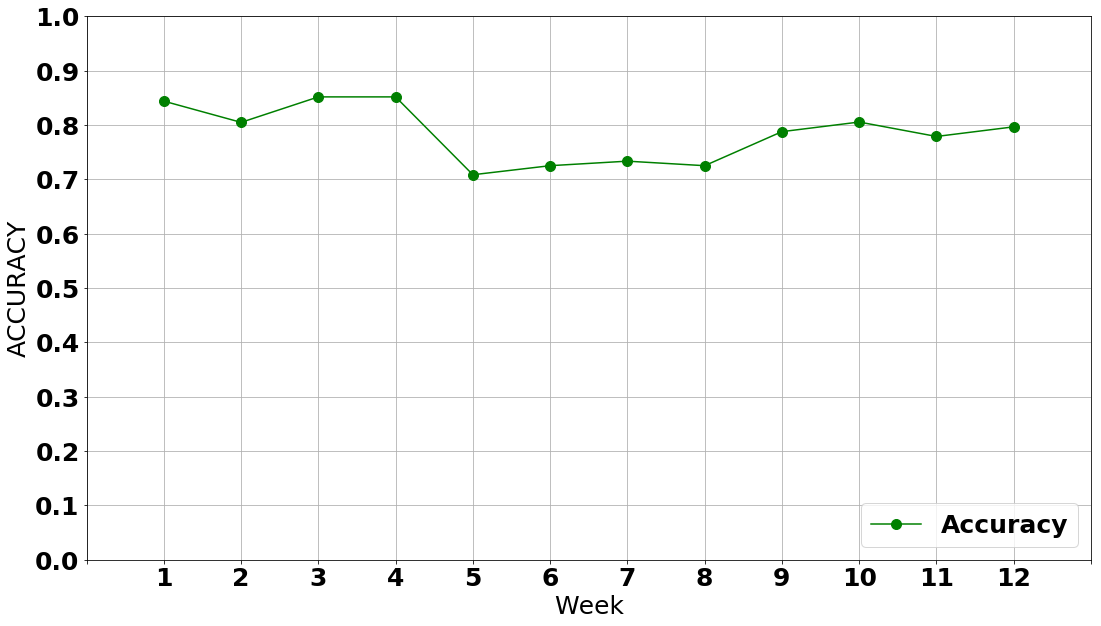

In [14]:
plot_metric(metrics, 'accuracy')

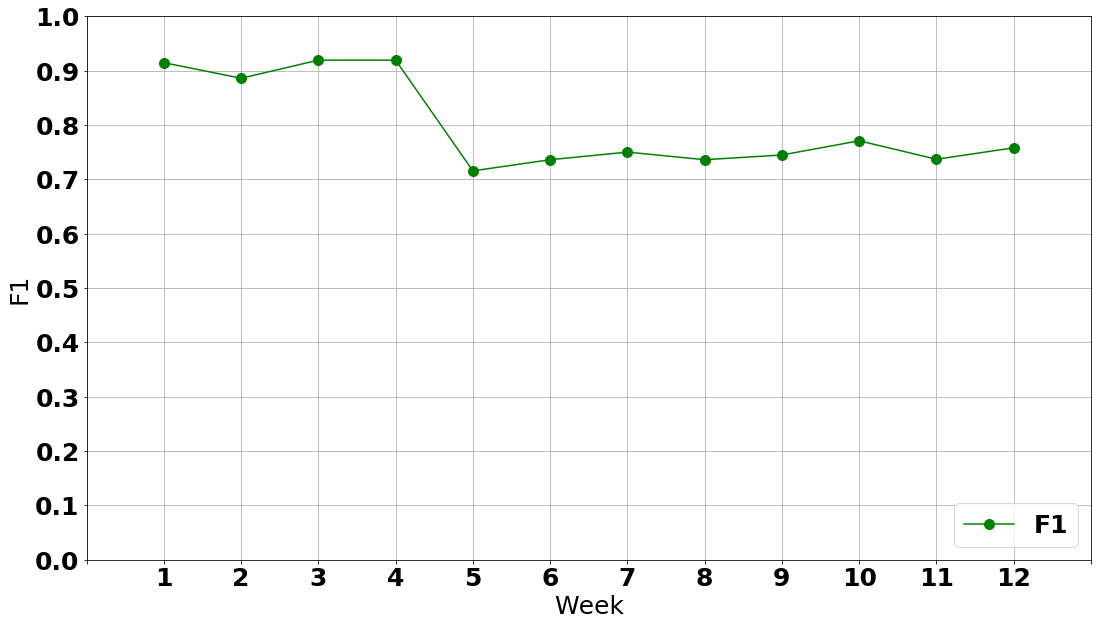

In [15]:
plot_metric(metrics, 'f1')

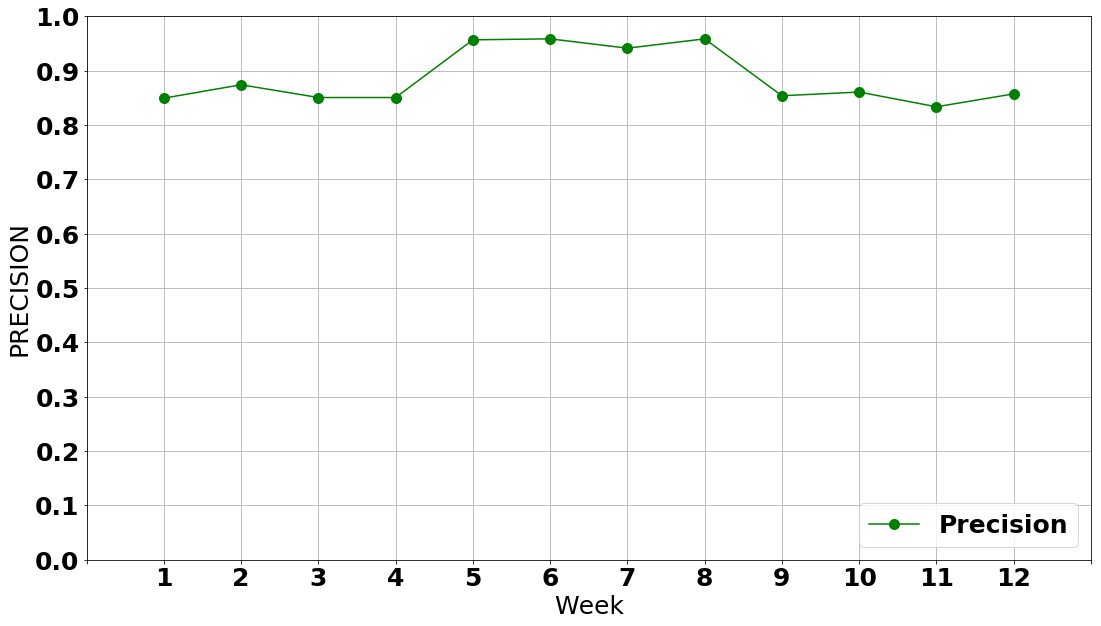

In [16]:
plot_metric(metrics, 'precision')

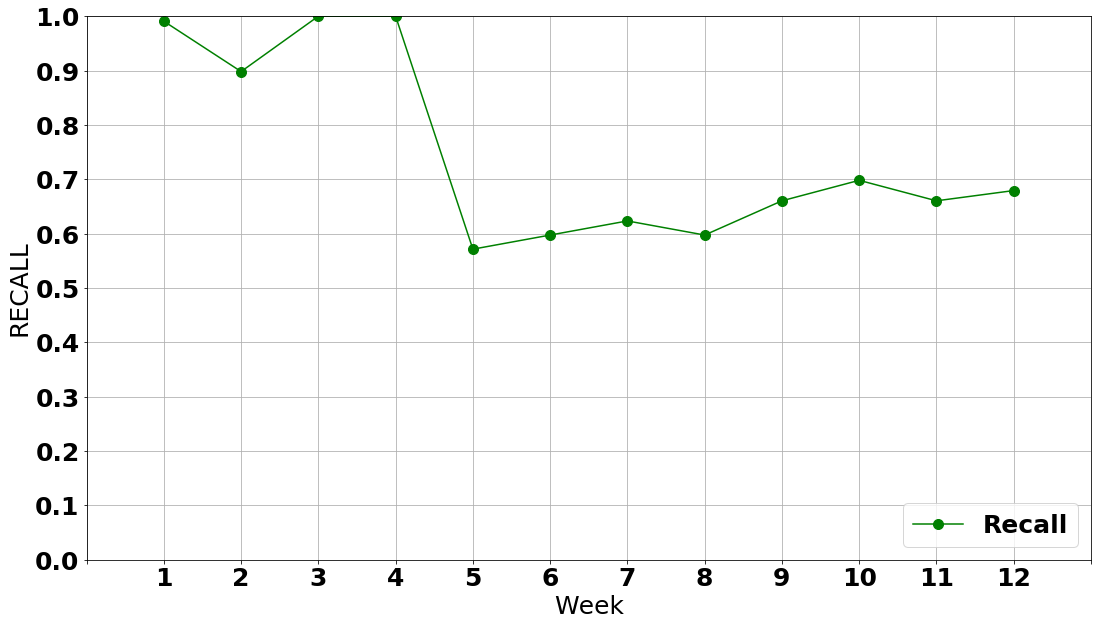

In [17]:
plot_metric(metrics, 'recall')

In [18]:
from IPython.core.display import display, HTML

def confusion_matrix_html(metrics):
    return display(HTML("""<!DOCTYPE html>
    <html>
    <head>
    <style>
    p {
        align: left;
    }
    th {
        text-align: center;
        white-space: nowrap;
        font-size: 13pt;
    }
    td {
        text-align: center;
        font-size: 13pt;
    }
    table {
        empty-cells: hide;
    }
    </style>
    </head>
    <body>
    <p> Passing rate = """ + str("{:.2%}".format(metrics['passing_rate']))  + """ <br>
    Accuracy = """ + str("{:.2%}".format(metrics['accuracy']))  + """ <br>
    Precision: True Positives / (True Positives + False Positives) = """ + str("{:.2%}".format(metrics['precision'])) + """ <br>
    Recall: (True Positives + True Negatives) / All = """ + str("{:.2%}".format(metrics['recall'])) + """ <br>
    F1: 2 * (Precision * Recall) / (Precision + Recall) = """ + str("{:.2%}".format(metrics['f1'])) + """
    </p> <br>
    <table
        class="table table-bordered table-hover"
        border="1" style="width:100%">
    <tr>
        <th></th>
        <th></th>
        <th style="text-align:center" colspan="2"> Predicted Condition </th>
        <th></th>
    </tr>
    <tr>
        <th></th>
        <th style="text-align:center"> Total Population </th>
        <th style="text-align:center"> Predicted Condition Positive </th>
        <th style="text-align:center"> Predicted Condition Negative </th>
        <th></th>
    </tr>
    <tr>
        <th style="text-align:center" valign="center" rowspan="2"> True <br> Condition </th>
        <td style="text-align:center"> Condition <br> Positive </td>
        <td style="text-align:center"> True positive <br> """  + str(metrics['true_positives']) + """ </td>
        <td style="text-align:center"> False Negative <br> (Type II error) <br> """  + str(metrics['false_negatives']) + """</td>
        <th style="text-align:center"> Recall<br>"""  + str("{:.2%}".format(metrics['recall'])) + """</th>
    </tr>
    <tr>
        <td style="text-align:center"> Condition <br> Negative </td>
        <td style="text-align:center"> False Positive <br> (Type I error) <br> """  + str(metrics['false_positives']) + """ </td>
        <td style="text-align:center"> True negative <br> """  + str(metrics['true_negatives']) + """ </td>
        <td></td>
    </tr>
    <tr>
        <th></th>
        <th style="text-align:center"> Accuracy <br> """  + str("{:.2%}".format(metrics['accuracy'])) + """ </th>
        <th style="text-align:center"> Precision <br> """  + str("{:.2%}".format(metrics['precision'])) + """ </th>
        <th></th>
        <th style="text-align:center"> F1 <br> """  + str("{:.2%}".format(metrics['f1'])) + """ </th>
    </tr>
    </table>
    </body>
    </html>
    """))

In [19]:
confusion_matrix_html(metrics[4]) # week 4

In [20]:
confusion_matrix_html(metrics[8]) # week 8

In [21]:
confusion_matrix_html(metrics[12]) # week 12